# Classifying the language of the last name via RNN

The idea is to one hot encode characters and then create dense embeddings for them based upon some classification problem, such as predicting the next letter or predicting nationality of last name (a common example).

## Support code

In [63]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
#from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [64]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float,
          mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [65]:
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

## Load

Let's download [training](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_train.csv.gz) and [testing](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_test.csv.gz) data for last names.   This data set is a bunch of last names and the nationality or language. 

In [66]:
df_train = pd.read_csv("data/names_train.csv", header=None)
df_train.columns = ['name','language']
df_test = pd.read_csv("data/names_train.csv", header=None)
df_test.columns = ['name','language']

In [67]:
df_train.shape, df_test.shape

((13374, 2), (13374, 2))

In [68]:
df_train.head(2)

,name,language
0,Adsit,Czech
1,Ajdrna,Czech


## Clean

In [69]:
badname = df_train['name']=='To The First Page'
df_train[badname]

,name,language
8340,To The First Page,Russian
8341,To The First Page,Russian
8342,To The First Page,Russian
8343,To The First Page,Russian
8344,To The First Page,Russian
8345,To The First Page,Russian
8346,To The First Page,Russian
8347,To The First Page,Russian
8348,To The First Page,Russian
8349,To The First Page,Russian


In [70]:
comma = df_train['name'].str.contains(',') # might as well keep
df_train[comma]

,name,language
5976,"Jevolojnov,",Russian
6549,"Lytkin,",Russian


In [71]:
df_train[df_train['name'].str.contains("'")][:3] # there are ok so keep quote

,name,language
3609,Awak'Yan,Russian
4454,Dan'Ko,Russian
4471,Dar'Kin,Russian


In [72]:
badname = df_train['name']=='To The First Page'
df_train = df_train[~badname]

badname = df_test['name']=='To The First Page'
df_test = df_test[~badname]

In [73]:
df_train['name'] = df_train['name'].str.lower()
df_test['name'] = df_test['name'].str.lower()

In [74]:
def maxlen(strings:Sequence[str]) -> int:
    return max([len(l) for l in strings])

max_len = max(maxlen(df_train['name']), maxlen(df_test['name']))
max_len

19

## Split out validation set

In [75]:
X, y = df_train[['name']], df_train['language']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
X_test, y_test = df_test[['name']], df_test['language']

## Get vocab

In [76]:
def vocab(strings):
    letters = [list(l) for l in strings]
    V = set([c for cl in letters for c in cl])
    V = sorted(list(V))
    ctoi = {c:i for i, c in enumerate(V)}
    return V, ctoi

In [77]:
V, ctoi = vocab(X['name'])
ctoi

{' ': 0,
 "'": 1,
 ',': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

## Encode target language (class)

Get categories from training only, not valid/test sets. Then apply cats to those set y's.

In [78]:
y_train = y_train.astype('category').cat.as_ordered()
y_cats = y_train.cat.categories
y_cats

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')

In [79]:
y_train = y_train.cat.codes
y_train.values[:10]

array([16,  4, 14,  4, 14, 14, 14, 14, 14, 14], dtype=int8)

In [80]:
y_valid = pd.Categorical(y_valid, categories=y_cats, ordered=True).codes
y_test = pd.Categorical(y_test, categories=y_cats, ordered=True).codes

In [81]:
y_valid[:5], y_test[:5]

(array([ 4,  9, 14,  4, 15], dtype=int8), array([2, 2, 2, 2, 2], dtype=int8))

## One-hot encode each letter of each name

Each name becomes a matrix of size vocab_size x max_len. Each column represents a char and we pad with zeros out to max_len number of columns since tensors have to be same length in same dimension. 

This approach is wasteful in that it expands each word to len of longest but avoids having to pad explicitly, simplifying the training process.

In [82]:
def onehot(strings:Sequence[str], V, ctoi, max_len=None) -> torch.tensor:
    if max_len is None:
        max_len = maxlen(strings)
    X_onehot = torch.zeros(len(strings),len(V),max_len)
    for i,name in enumerate(strings):
        onehot = torch.zeros((len(V),max_len))
        for j,c in enumerate(name):
            onehot[ctoi[c],j] = 1
        X_onehot[i] = onehot
    return X_onehot

In [83]:
sample = ['cat','a','at'] # always debug with a small representative example
o = onehot(sample, *vocab(sample))
o

tensor([[[0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]]])

In [84]:
o[0,1].reshape(-1,1)

tensor([[1.],
        [0.],
        [0.]])

In [85]:
X_train_onehot = onehot(X_train['name'], V, ctoi, max_len=max_len).to(device)
X_train_onehot[0].shape

torch.Size([29, 19])

In [86]:
X_valid_onehot = onehot(X_valid['name'], V, ctoi, max_len=max_len).to(device)
X_valid_onehot[0].shape

torch.Size([29, 19])

## RNN model

Switching to W, U, V notation from $W_hh$ etc... from [Goodfellow and Yoshua Bengio and Aaron Courville book](https://www.deeplearningbook.org/contents/rnn.html)

We have a sequence of one-hot vectors for each word and need to predict a language for each sequence.  We need to know: vocab size (len of one hots), hidden len, and the number of target classes (langs).

We must combine a name's onehots into a single vector representing word then use a simple dense linear layer to make a prediction

$$
h^{(t)} = \text{ReLU}( W h^{(t-1)} + U x^{(t)} )
$$

where $t$ iterates through name length (or max pad length).

Note this is same as concatenating old state and current input vector and applying a single $W$ matrix of size nhidden x (nhidden+|V|):

$$
h^{(t)} = \text{ReLU}( W [h^{(t-1)};x^{(t)}] )
$$

The output is avail at every char but we only need the last one:

$$
y^{(t)} = V h^{(t)}
$$

This $V$ acts like the last dense linear layer which converts the hidden state to likelihood of each target class.

*What are the embeddings?* I think those are the final $h^{(t)}$ vectors, one of which is computed per name.  What are char-vec embeddings? Maybe $U$?

### Record-by-record (slow)

In [ ]:
class LastNameRNN_slow(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LastNameRNN_slow, self).__init__()
#         print("Model: ",input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Help avoid vanishing gradient. Start with identity, which has
        # effect of summing char vector embeddings
        self.W  = torch.eye(hidden_size, hidden_size).double() #randn(hidden_size, hidden_size, std=0.01).double()
        self.U  = torch.eye(hidden_size, input_size).double()
        self.V  = torch.eye(output_size, hidden_size).double()
        self.W  = nn.Parameter(self.W)
        self.U  = nn.Parameter(self.U)
        self.V  = nn.Parameter(self.V)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        namelen = X.shape[2]
        # record softmax vec of output_size for each record
        o = torch.zeros((batch_size, self.output_size)).double().to(device)
        for i in range(batch_size):
            # Reset hidden state (history) at start of every record
            # Use same W and U matrices for all records until SGD update step
            h = torch.zeros((self.hidden_size, 1)).double().to(device)
            for j in range(namelen):  # for all chars in max name length
#                 print(h.shape, X[i].shape, X[i,:,j].shape, self.U.shape)
                h = self.W.mm(h) + self.U.mm(X[i,:,j].reshape(-1,1))
                h = torch.relu(h)  # better than sigmoid for vanishing gradient
            # we now have an h vector that is the embedding for the ith record
            # we have encoded/embedded the X[i] record into h
            # compute an output value, one per record
            ot = self.V.mm(h)
#             o[i] = F.softmax(ot.reshape(-1))
            o[i] = ot.reshape(-1)
        return o

In [88]:
# test model
rnn = LastNameRNN_slow(input_size=len(V), hidden_size=10, output_size=len(y_cats)).to(device)
y_pred = rnn(torch.tensor(X_train_onehot[:100],device=device).double())
y_pred

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64,
       grad_fn=<CopySlices>)

## Train

In [89]:
def ctrain(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
           epochs=350,
           test_size=0.20,
           learning_rate = 0.002,
           batch_size=32,
           weight_decay=1.e-4,
           loss_fn=F.cross_entropy,
           metric=accuracy_score,
           print_every=30):
    "Train a regressor"
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
#             print("y pred", y_prob, "batch_y", batch_y)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()

        with torch.no_grad():
            loss        = loss_fn(model(train_data.tensors[0]), train_data.tensors[1])
            loss_valid  = loss_fn(model(valid_data.tensors[0]), valid_data.tensors[1])
            y_prob = model(train_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_train = metric(y_pred.cpu(), train_data.tensors[1].cpu())
            y_prob = model(valid_data.tensors[0])
            y_prob = F.softmax(y_prob, dim=1)
            y_pred = torch.argmax(y_prob, dim=1)
            metric_valid = metric(y_pred.cpu(), valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} loss {loss:7.4f}, {loss_valid:7.4f}   {metric.__class__.__name__} {metric_train:4.3f}, {metric_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

Epoch   0 loss  1.6141,  1.6637   function 0.479, 0.481
Epoch   1 loss  1.5484,  1.6540   function 0.537, 0.516
Epoch   2 loss  1.4791,  1.6350   function 0.525, 0.502
Epoch   3 loss  1.3509,  1.4839   function 0.628, 0.581
Epoch   4 loss  1.4961,  1.8364   function 0.639, 0.580
Epoch   5 loss  1.4399,  1.6613   function 0.609, 0.567
Epoch   6 loss  1.3239,  1.5303   function 0.640, 0.594
Epoch   7 loss  1.3568,  1.5257   function 0.626, 0.596
Epoch   8 loss  1.3702,  1.5336   function 0.634, 0.589
Epoch   9 loss  1.3771,  1.6518   function 0.606, 0.560


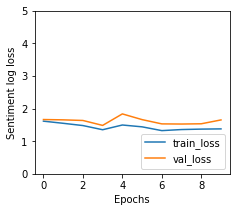

In [90]:
rnn = LastNameRNN_slow(input_size=len(V),
                      hidden_size=100,
                      output_size=len(y_cats)).to(device)
subset=1000
train = TensorDataset(X_train_onehot[:subset].double().to(device), torch.tensor(y_train[:subset].values).long().to(device))
valid = TensorDataset(X_valid_onehot[:subset].double().to(device), torch.tensor(y_valid[:subset]).long().to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=10,
                        learning_rate=.02,
                        weight_decay=0.00001,
                        batch_size=32,
                        print_every=1)

plot_history(history, yrange=(0,5))

### Timestep-by-step (fast)

Epoch   0 loss  1.8247,  1.8289   function 0.467, 0.462
Epoch   1 loss  1.7246,  1.7263   function 0.467, 0.462
Epoch   2 loss  1.5241,  1.5304   function 0.553, 0.541
Epoch   3 loss  1.4584,  1.4653   function 0.564, 0.555
Epoch   4 loss  1.4251,  1.4365   function 0.569, 0.556
Epoch   5 loss  1.4052,  1.4194   function 0.570, 0.559
Epoch   6 loss  1.3856,  1.4023   function 0.575, 0.561
Epoch   7 loss  1.3676,  1.3852   function 0.578, 0.565
Epoch   8 loss  1.3555,  1.3742   function 0.581, 0.570
Epoch   9 loss  1.3353,  1.3565   function 0.589, 0.584
Epoch  10 loss  1.3192,  1.3434   function 0.607, 0.605
Epoch  11 loss  1.3033,  1.3307   function 0.624, 0.621
Epoch  12 loss  1.2848,  1.3176   function 0.623, 0.618
Epoch  13 loss  1.2746,  1.3092   function 0.626, 0.619
Epoch  14 loss  1.2609,  1.2966   function 0.632, 0.625
Epoch  15 loss  1.2408,  1.2790   function 0.647, 0.646
Epoch  16 loss  1.2397,  1.2815   function 0.645, 0.641
Epoch  17 loss  1.2187,  1.2659   function 0.655

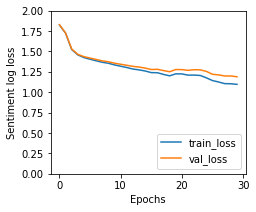

In [147]:
rnn = LastNameRNN(input_size=len(V),
                  hidden_size=50,
                  output_size=len(y_cats)).to(device)
subset=10_000
train = TensorDataset(X_train_onehot[:subset].to(device), torch.tensor(y_train[:subset].values).long().to(device))
valid = TensorDataset(X_valid_onehot[:subset].to(device), torch.tensor(y_valid[:subset]).long().to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=30,
                        learning_rate=.001,
                        weight_decay=0.000001,#002,
                        batch_size=64,
                        print_every=1)

plot_history(history, yrange=(0,2))

In [140]:
class LastNameRNN_split(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LastNameRNN_split, self).__init__()
#         print("Model: ",input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.W  = torch.eye(hidden_size, hidden_size)
        self.U  = torch.eye(hidden_size, input_size)
        self.V  = torch.eye(output_size, hidden_size)
        self.W  = nn.Parameter(self.W)
        self.U  = nn.Parameter(self.U)
        self.V  = nn.Parameter(self.V)

#         self.W  = nn.Linear(hidden_size+input_size, hidden_size)
#         self.V  = nn.Linear(hidden_size, output_size)

    def forward(self, X):
#         print("X", X.shape)
        batch_size = X.shape[0]
        namelen = X.shape[2]
        # record softmax vec of output_size for each record
        o = torch.zeros((batch_size, self.output_size)).to(device)
        # now that we do all char j in a batch, h is a matrix
        h = torch.zeros((self.hidden_size, batch_size)).to(device)
        for j in range(namelen):  # for all chars in max name length
            # xj is batchsize x |V| but U is hidden x |V| so need transpose
            xj = X[:,:,j].T # jth char dim for all records in batch
#             print(self.W.shape, h.shape, self.U.shape, xj.shape)
            h = self.W.mm(h) + self.U.mm(xj)
            h = torch.relu(h)  # better than sigmoid for vanishing gradient
        # we now have an h vector that is the embedding for the ith record
        # we have encoded/embedded the X[i] record into h
        # compute an output value, one per record
        ot = self.V.mm(h).T
#             o[i] = F.softmax(ot.reshape(-1))
#         print("ot shape", ot.shape, h.shape)
        return ot

Epoch   0 loss  1.3741,  1.3873   function 0.589, 0.579
Epoch   1 loss  1.2153,  1.2252   function 0.640, 0.640
Epoch   2 loss  1.1475,  1.1667   function 0.651, 0.652
Epoch   3 loss  1.0943,  1.1198   function 0.660, 0.659
Epoch   4 loss  1.0483,  1.0808   function 0.680, 0.675
Epoch   5 loss  1.0049,  1.0448   function 0.697, 0.692
Epoch   6 loss  0.9687,  1.0172   function 0.713, 0.701
Epoch   7 loss  0.9399,  0.9991   function 0.718, 0.705
Epoch   8 loss  0.9135,  0.9828   function 0.726, 0.703
Epoch   9 loss  0.8912,  0.9687   function 0.733, 0.706
Epoch  10 loss  0.8700,  0.9555   function 0.739, 0.707
Epoch  11 loss  0.8522,  0.9455   function 0.742, 0.710
Epoch  12 loss  0.8373,  0.9381   function 0.747, 0.714
Epoch  13 loss  0.8255,  0.9323   function 0.752, 0.719
Epoch  14 loss  0.8097,  0.9244   function 0.757, 0.721
Epoch  15 loss  0.7977,  0.9193   function 0.759, 0.725
Epoch  16 loss  0.7862,  0.9128   function 0.763, 0.727
Epoch  17 loss  0.7792,  0.9112   function 0.763

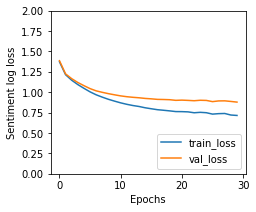

In [145]:
rnn = LastNameRNN_split(input_size=len(V),
                      hidden_size=50,
                      output_size=len(y_cats)).to(device)
subset=10_000
train = TensorDataset(X_train_onehot[:subset].to(device), torch.tensor(y_train[:subset].values).long().to(device))
valid = TensorDataset(X_valid_onehot[:subset].to(device), torch.tensor(y_valid[:subset]).long().to(device))
model, history = ctrain(rnn, train, valid,
#                         loss_fn=torch.nn.BCELoss(),
                        loss_fn=F.cross_entropy,
                        metric=accuracy_score,
                        epochs=30,
                        learning_rate=.001,
                        weight_decay=0.000001,#002,
                        batch_size=64,
                        print_every=1)

plot_history(history, yrange=(0,2))

Interesting.  Separated W and U seems to get better results, even though it should be equivalent. I must have some other different like precision or other numerical diffs.

## Error messages

For TensorDataset, if you see `TypeError: 'int' object is not callable`, it means you've passed a numpy array.

If it says "expected Long got Char", it might mean int8 not char.